In [1]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
from random import sample

from pickle import dump
from pickle import load

In [2]:
air = pd.read_csv('/content/drive/MyDrive/560 -Team Random/dataset/house_price_air_quality.csv')
air['Year'] = air['Year'].apply(lambda x: 2022 - int(x))

oil = pd.read_csv('/content/drive/MyDrive/560 -Team Random/dataset/house_price_oil_wells.csv')
#water = pd.read_csv('/content/drive/MyDrive/560 -Team Random/dataset/house_price_water_quality.csv')

In [3]:
# rmse metric for tensorflow nn model
def rmse(y_true, y_pred):
    return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true)))

In [4]:
def prepareTrainingData(X_trian, X_test, numScaled):
  # scale data to range [0, 1]
  scaler = StandardScaler()  

  # separate country's OHE so that OHE won't be scaled by scaler
  # fit only on the air quality columns of training data
  scaler.fit(X_trian.iloc[:, :numScaled].values)
  #dump(scaler, open('/content/drive/MyDrive/560 -Team Random/colab/water_scaler.pkl', 'wb'))
  #scaler = load(open('/content/drive/MyDrive/560 -Team Random/colab/air_scaler.pkl', 'rb'))

  X_train_scaled_columns = scaler.transform(X_trian.iloc[:, :numScaled])  
  X_test_scaled_columns = scaler.transform(X_test.iloc[:, :numScaled]) 

  # numScaled:end are columns for the OHE of county
  X_train = np.concatenate([X_train_scaled_columns, X_trian.iloc[:, numScaled:]], axis=1)
  X_test = np.concatenate([X_test_scaled_columns, X_test.iloc[:, numScaled:]], axis=1)

  return X_train, X_test

In [5]:
# print the model performance in terms of RMSE and R-squared
def printPerformance(model, X_test, y_test, pollution, model_name='DNN'):
  pred = model.predict(X_test)
  pred = np.ravel(pred)

  model_rmse = rmse(y_test, pred).numpy()
  print('rmse for {} - housing price Tensorflow {} model is {}'.format(pollution, model_name, model_rmse))

  r2 = r2_score(y_test, pred)
  print('r-squared for the {} - housing price Tensorflow {} model is {}'.format(pollution, model_name, r2))

In [6]:
# visual comparsion of the model performance
def compare(model, x_test, y_true, sample_size, title):
  selected_index = sample(list(np.arange(0, len(x_test), 1)), 100)
  y_pred = list()
  y_true_selected = list()
  for i in selected_index:
    x_i = x_test[i].reshape(1, -1)
    pred_result = model.predict(x_i)
    pred_result = np.ravel(pred_result)
    y_pred.append(pred_result)
    y_true_selected.append(y_true[i])

  plt.figure(figsize=(20,10))
  plt.plot(y_pred, label='Predicted housing price')
  plt.plot(y_true_selected, label='Actual housing price')
  plt.legend(fontsize = 'xx-large')
  plt.title(title, fontsize=20)
  plt.xlabel('Random datapoints index', fontsize=18)
  plt.ylabel('Housing price', fontsize=18)
  plt.show()

In [ ]:
# Air quality - housing price

In [7]:
air.head()

,price,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,...,Siskiyou,Solano,Sonoma,Stanislaus,Sutter,Tehama,Tulare,Tuolumne,Ventura,Yolo
0,226149.0,22,366,293,59,11,2,1,0,209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,226149.0,21,365,290,57,12,6,0,0,178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,226149.0,20,365,272,71,15,6,1,0,201,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,226149.0,19,365,300,53,9,3,0,0,172,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,226149.0,18,366,236,114,16,0,0,0,136,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
included_features = ['price', 'Year', 'Good Days', 'Moderate Days',
                    'Unhealthy for Sensitive Groups Days', 'Unhealthy Days',
                    'Very Unhealthy Days', 'Hazardous Days',
                    'Median AQI', 'Days CO', 'Days NO2', 
                    'Days Ozone', 'Days SO2', 'Days PM2.5', 'Days PM10', 'house_price_age',
                    'Alameda', 'Amador', 'Butte', 'Calaveras', 'Del Norte', 'El Dorado',
                    'Fresno', 'Glenn', 'Humboldt', 'Kern', 'Kings', 'Lake', 'Lassen',
                    'Los Angeles', 'Madera', 'Marin', 'Mariposa', 'Mendocino', 'Merced',
                    'Mono', 'Monterey', 'Napa', 'Nevada', 'Orange', 'Placer', 'Plumas',
                    'Riverside', 'Sacramento', 'San Benito', 'San Bernardino', 'San Diego',
                    'San Francisco', 'San Joaquin', 'San Luis Obispo', 'San Mateo',
                    'Santa Barbara', 'Santa Clara', 'Santa Cruz', 'Shasta', 'Siskiyou',
                    'Solano', 'Sonoma', 'Stanislaus', 'Sutter', 'Tehama', 'Tulare',
                    'Tuolumne', 'Ventura', 'Yolo']
air_feature = air[included_features]

49

In [9]:
good_days = 100 
moderate_days = 110
unhealthy_days_sens = 100
unhealthy_days = 100
very_unhealthy_days = 20
hazard_days = 26
# above should sum up to 365

median_aqi = 50 # 5 to 130

co_days = 2
no2_days = 129
ozone_days = 182
so2_days = 0
pm2_days = 53
pm10_days = 0
# above should sum up 

price_age = 30 # 0 to 32

air_pollution = {
    'Good Days': good_days,
    'Moderate Days': moderate_days,
    'Unhealthy for Sensitive Groups Days': unhealthy_days_sens,
    'Unhealthy Days': unhealthy_days,
    'Very Unhealthy Days': very_unhealthy_days,
    'Hazardous Days': hazard_days,
    'Median AQI': median_aqi,
    'Days CO': co_days,
    'Days NO2': no2_days,
    'Days Ozone': ozone_days,
    'Days SO2': so2_days,
    'Days PM2.5': pm2_days, 
    'Days PM10': pm10_days,
    'house_price_age': price_age 
}

air_county = ['Alameda', 'Amador', 'Butte', 'Calaveras', 'Del Norte', 'El Dorado',
              'Fresno', 'Glenn', 'Humboldt', 'Kern', 'Kings', 'Lake', 'Lassen',
              'Los Angeles', 'Madera', 'Marin', 'Mariposa', 'Mendocino', 'Merced',
              'Mono', 'Monterey', 'Napa', 'Nevada', 'Orange', 'Placer', 'Plumas',
              'Riverside', 'Sacramento', 'San Benito', 'San Bernardino', 'San Diego',
              'San Francisco', 'San Joaquin', 'San Luis Obispo', 'San Mateo',
              'Santa Barbara', 'Santa Clara', 'Santa Cruz', 'Shasta', 'Siskiyou',
              'Solano', 'Sonoma', 'Stanislaus', 'Sutter', 'Tehama', 'Tulare',
              'Tuolumne', 'Ventura', 'Yolo']


# -----------------------------------------------------------------------

spudage = 50 # 29 to 102
well_ratio = 0.1 # 0 to 0.3

oil_pollution = {
    'SpudAge': spudage,
    'ActiveWellRatio': well_ratio,
    'house_price_age': price_age
}

oil_county = ['Alameda','Amador', 'Butte', 'Del Norte', 'Fresno', 'Glenn', 'Humboldt', 'Kern',
              'Kings', 'Lake', 'Lassen', 'Los Angeles', 'Madera', 'Marin',
              'Mendocino', 'Merced', 'Mono', 'Monterey', 'Napa', 'Orange', 'Placer',
              'Riverside', 'Sacramento', 'San Benito', 'San Bernardino', 'San Diego',
              'San Joaquin', 'San Luis Obispo', 'San Mateo', 'Santa Barbara',
              'Santa Clara', 'Santa Cruz', 'Shasta', 'Siskiyou', 'Solano', 'Sonoma',
              'Stanislaus', 'Sutter', 'Tehama', 'Tulare', 'Ventura', 'Yolo', 'Yuba']


# ------------------------------------------------------------------------------------

result = 300 # -1 to 5000000.0
polluted = 1 # 0 or 1
selected_pollution = ['Bromacil', 'Carbofuran', 'Diuron'] # select from water_pollution_list

water_pollution = {
    'Result': result,
    'Polluted': polluted,
    'house_price_age': price_age
}

water_pollution_list = ['(Aminomethyl)phosphonic acid',
                        '1,1,1,2-Tetrachloroethane',
                        '1,1,1-Trichloroethane',
                        '1,1,2,2-Tetrachloroethane',
                        '1,1,2-Trichloroethane',
                        '1,1,2-Trichlorotrifluoroethane',
                        '1,1-Dichloroethane',
                        '1,1-Dichloroethene',
                        '1,1-Dichloropropene',
                        '1,2,3-Trichlorobenzene',
                        '1,2,3-Trichloropropane',
                        '1,2,4-Trichlorobenzene',
                        '1,2,4-Trimethylbenzene',
                        '1,2-Dibromo-3-chloropropane (DBCP)',
                        '1,2-Dibromoethane (EDB)',
                        '1,2-Dichlorobenzene',
                        '1,2-Dichloroethane',
                        '1,2-Dichloropropane',
                        '1,3,5-Trimethylbenzene',
                        '1,3-Dichlorobenzene',
                        '1,3-Dichloropropane',
                        '1,4-Dichlorobenzene',
                        '1-Naphthol',
                        '2,2-Dichloropropane',
                        '2,3,7,8-Tetrachlorodibenzo-p-dioxin',
                        '2,3-Dibromopropionic acid',
                        '2,4,5-T',
                        '2,4,5-TP (Silvex)',
                        '2,4-D',
                        '2,4-DB',
                        '2-Chlorotoluene',
                        '3,5-Dichlorobenzoic Acid',
                        '3-Hydroxycarbofuran',
                        "4,4'-Dibromoctafluorobiphenyl",
                        '4-Bromofluorobenzene',
                        '4-Chlorotoluene',
                        '4-Isopropyltoluene',
                        '4-Nitrophenol',
                        '5-Day Biochemical Oxygen Demand',
                        'Acenaphthene',
                        'Acenaphthylene',
                        'Acephate',
                        'Acifluorfen',
                        'Alachlor',
                        'Aldicarb',
                        'Aldicarb sulfone',
                        'Aldicarb sulfoxide',
                        'Aldrin',
                        'Alkalinity',
                        'Allethrin',
                        'Aminomethylphosphonic Acid (AMPA)',
                        'Anthracene',
                        'Ash Free Dry Mass',
                        'Atrazine',
                        'Azinphos methyl (Guthion)',
                        'BHC-alpha',
                        'BHC-beta',
                        'BHC-delta',
                        'BHC-gamma (Lindane)',
                        'Benfluralin',
                        'Bentazon',
                        'Benz(a)anthracene',
                        'Benzene',
                        'Benzo(a)pyrene',
                        'Benzo(b)fluoranthene',
                        'Benzo(ghi)perylene',
                        'Benzo(k)fluoranthene',
                        'Bicarbonate (HCO3-)',
                        'Bifenthrin',
                        'Biochemical Oxygen Demand',
                        'Bis(2-ethylhexyl) adipate',
                        'Bolstar',
                        'Bromacil',
                        'Bromide',
                        'Bromobenzene',
                        'Bromochloroacetic Acid (BCAA)',
                        'Bromochloroacetonitrile',
                        'Bromochloromethane',
                        'Bromodichloromethane',
                        'Bromoform',
                        'Bromomethane',
                        'Butachlor',
                        'Captan',
                        'Carbaryl',
                        'Carbofuran',
                        'Carbon tetrachloride',
                        'Carbonaceous Biochemical Oxygen Demand',
                        'Carbophenothion (Trithion)',
                        'Chlordane',
                        'Chlorobenzene',
                        'Chloroethane',
                        'Chloroform',
                        'Chloromethane',
                        'Chlorophyll a',
                        'Chloropicrin',
                        'Chloropropham',
                        'Chlorothalonil',
                        'Chlorpropham',
                        'Chlorpyrifos',
                        'Chorpropham',
                        'Chrysene',
                        'Clostridium perfringens',
                        'Color',
                        'Conductance',
                        'Coumaphos',
                        'Cryptosporidium',
                        'Cyanazine',
                        'Cyfluthrin',
                        'Cypermethrin',
                        'DDD (all isomers)',
                        'DDE (all isomers)',
                        'DDT (all isomers)',
                        'Dacthal (DCPA)',
                        'Dalapon',
                        'Deltamethrin/Tralomethrin',
                        'Demeton (Demeton O + Demeton S)',
                        'Demeton-O',
                        'Demeton-S',
                        'Diazinon',
                        'Dibenz(a,h)anthracene',
                        'Dibromoacetic Acid (DBAA)',
                        'Dibromoacetonitrile',
                        'Dibromochloromethane',
                        'Dibromomethane',
                        'Dicamba',
                        'Dichloran',
                        'Dichloroacetic Acid (DCAA)',
                        'Dichloroacetonitrile',
                        'Dichlorodifluoromethane',
                        'Dichloroprop',
                        'Dichlorprop',
                        'Dichlorvos',
                        'Dicofol',
                        'Dieldrin',
                        'Dimethoate',
                        'Dinoseb (DNPB)',
                        'Diquat',
                        'Dissolved Acid Hydrolyzable Phosphorus',
                        'Dissolved Aluminum',
                        'Dissolved Ammonia',
                        'Dissolved Antimony',
                        'Dissolved Arsenic',
                        'Dissolved Barium',
                        'Dissolved Beryllium',
                        'Dissolved Bicarbonate (HCO3-)',
                        'Dissolved Boron',
                        'Dissolved Bromide',
                        'Dissolved Cadmium',
                        'Dissolved Calcium',
                        'Dissolved Carbonate (CO3--)',
                        'Dissolved Chloride',
                        'Dissolved Chromium',
                        'Dissolved Chromium, hexavalent (Cr6+)',
                        'Dissolved Cobalt',
                        'Dissolved Copper',
                        'Dissolved Fluoride',
                        'Dissolved Hardness',
                        'Dissolved Hydroxide (OH-)',
                        'Dissolved Iron',
                        'Dissolved Lead',
                        'Dissolved Lithium',
                        'Dissolved Magnesium',
                        'Dissolved Manganese',
                        'Dissolved Mercury',
                        'Dissolved Methylmercury',
                        'Dissolved Molybdenum',
                        'Dissolved Nickel',
                        'Dissolved Nitrate',
                        'Dissolved Nitrate + Nitrite',
                        'Dissolved Nitrite',
                        'Dissolved Organic Carbon',
                        'Dissolved Organic Nitrogen',
                        'Dissolved Phosphorus',
                        'Dissolved Potassium',
                        'Dissolved Selenium',
                        'Dissolved Silica (SiO2)',
                        'Dissolved Silver',
                        'Dissolved Sodium',
                        'Dissolved Strontium',
                        'Dissolved Sulfate',
                        'Dissolved Thallium',
                        'Dissolved Total Kjeldahl Nitrogen',
                        'Dissolved Vanadium',
                        'Dissolved Zinc',
                        'Dissolved ortho-Phosphate',
                        'Disulfoton',
                        'Diuron',
                        'Endosulfan sulfate',
                        'Endosulfan-I',
                        'Endosulfan-II',
                        'Endothal',
                        'Endrin',
                        'Endrin aldehyde',
                        'Escherichia coli',
                        'Esfenvalerate',
                        'Ethion',
                        'Ethoprop',
                        'Ethyl benzene',
                        'Ethylbenzene',
                        'Ethylene Dibromide',
                        'Ethylenethiourea',
                        'Fecal Coliform',
                        'Fensulfothion',
                        'Fenthion',
                        'Fenvalerate',
                        'Fluoranthene',
                        'Fluorene',
                        'Formetanate hydrochloride',
                        'Giardia lamblia',
                        'Glyphosate',
                        'Haloacetic Acid Formation Potential (HAAFP)',
                        'Heptachlor',
                        'Heptachlor epoxide',
                        'Hexachlorobenzene',
                        'Hexachlorobutadiene',
                        'Hexachlorocyclopentadiene',
                        'Indeno(1,2,3-cd)pyrene',
                        'Inositol 1,4,5-Trisphosphate',
                        'Isopropylbenzene',
                        'MCPA',
                        'MCPP',
                        'Malathion',
                        'Merphos',
                        'Methidathion',
                        'Methiocarb',
                        'Methomyl',
                        'Methoxychlor',
                        'Methyl tert-butyl ether (MTBE)',
                        'Methylene Blue Active Substances (MBAS)',
                        'Methylene chloride',
                        'Metolachlor',
                        'Metribuzin',
                        'Mevinphos',
                        'Molinate',
                        'Monobromoacetic Acid (MBAA)',
                        'Monochloroacetic Acid (MCAA)',
                        'Naled',
                        'Naphthalene',
                        'Napropamide',
                        'Norflurazon',
                        'Oil and Grease',
                        'Oxamyl',
                        'Oxyfluorfen',
                        "PCB's",
                        'PCB-1016',
                        'PCB-1221',
                        'PCB-1232',
                        'PCB-1242',
                        'PCB-1248',
                        'PCB-1254',
                        'PCB-1260',
                        'Parathion, Ethyl',
                        'Parathion, Methyl',
                        'Pendimethalin',
                        'Pentachloronitrobenzene (PCNB)',
                        'Pentachlorophenol (PCP)',
                        'Permethrin',
                        'Phenanthrene',
                        'Phenol',
                        'Pheophytin a',
                        'Phorate',
                        'Phosalone',
                        'Phosmet',
                        'Picloram',
                        'Prallethrin',
                        'Profenofos',
                        'Prometryn',
                        'Propachlor',
                        'Propargite',
                        'Propetamphos',
                        'Propoxur',
                        'Pyrene',
                        'Ronnel',
                        'Settleable Solids',
                        'Simazine',
                        'Soil Solids',
                        'Specific Conductance',
                        'Styrene',
                        'Sumithrin',
                        'Suspended + Volatile Suspended Solids',
                        'Suspended Solids',
                        'Tefluthrin',
                        'Tetrachloroethene',
                        'Tetrachloroethylene',
                        'Tetrachlorofluoromethane',
                        'Tetrachlorvinphos',
                        'Thiobencarb',
                        'Thionazine (Zinophos)',
                        'Tokuthion',
                        'Toluene',
                        'Total Alkalinity',
                        'Total Aluminum',
                        'Total Ammonia',
                        'Total Antimony',
                        'Total Arsenic',
                        'Total Asbestos, Chrysotile',
                        'Total Barium',
                        'Total Beryllium',
                        'Total Boron',
                        'Total Cadmium',
                        'Total Calcium',
                        'Total Chromium',
                        'Total Cobalt',
                        'Total Coliform',
                        'Total Copper',
                        'Total Cyanide',
                        'Total Dissolved Solids',
                        'Total Hardness',
                        'Total Iron',
                        'Total Kjeldahl Nitrogen',
                        'Total Lead',
                        'Total Lithium',
                        'Total Magnesium',
                        'Total Manganese',
                        'Total Mercury',
                        'Total Methylmercury',
                        'Total Molybdenum',
                        'Total Nickel',
                        'Total Oil and Grease',
                        'Total Organic Carbon',
                        'Total Organic Nitrogen',
                        'Total Parathion, ethyl & methyl',
                        'Total Phosphorus',
                        'Total Potassium',
                        'Total Selenium',
                        'Total Silica (SiO2)',
                        'Total Silver',
                        'Total Sodium',
                        'Total Strontium',
                        'Total Suspended Solids',
                        'Total Thallium',
                        'Total Vanadium',
                        'Total Xylene, (total)',
                        'Total Zinc',
                        'Total ortho-Phosphate',
                        'Toxaphene',
                        'Trichloroacetic Acid (TCAA)',
                        'Trichloroacetonitrile',
                        'Trichloroethene',
                        'Trichlorofluoromethane',
                        'Trichloronate',
                        'Triclopyr',
                        'Trifluralin',
                        'Trihalomethane Formation Potential (THMFP)',
                        'Turbidity',
                        'UV Absorbance @254nm',
                        'Vinyl chloride',
                        'Volatile Solids',
                        'Volatile Suspended Solids',
                        'Xylene, (total)',
                        'bis(2-Ethylhexyl) phthalate',
                        'cis-1,2-Dichloroethene',
                        'cis-1,3-Dichloropropene',
                        'l-Cyhalothrin',
                        'm + p Xylene',
                        'm-Xylene',
                        'n-Butylbenzene',
                        'n-Propylbenzene',
                        "o,p'-DDE",
                        'o-Xylene',
                        "p,p'-DDD",
                        "p,p'-DDE",
                        "p,p'-DDT",
                        'p-Xylene',
                        'pH',
                        's,s,s-Tributyl Phosphorotrithioate (DEF)',
                        'sec-Butylbenzene',
                        'tert-Butylbenzene',
                        'trans-1,2-Dichloroethene',
                        'trans-1,3-Dichloropropene']
water_pollution_index = dict()
for idx, name in enumerate(water_pollution_list):
  water_pollution_index[name] = idx

water_pollution_type = [0] * len(water_pollution_list)
for pollution in selected_pollution:
  water_pollution_type[water_pollution_index[pollution]] = 1


water_county = ['Alameda', 'Amador', 'Butte', 'Calaveras','Del Norte',
                'El Dorado','Fresno','Glenn','Humboldt','Kern','Kings',
                'Lake','Lassen','Los Angeles','Marin','Mendocino','Merced',
                'Mono','Monterey','Napa','Nevada','Placer','Plumas',
                'Riverside','Sacramento','San Benito','San Bernardino',
                'San Diego','San Joaquin','San Luis Obispo','Santa Barbara',
                'Santa Clara','Santa Cruz','Shasta','Siskiyou','Solano','Sonoma',
                'Stanislaus','Sutter','Tehama','Tulare','Tuolumne','Ventura',
                'Yolo','Yuba']

In [ ]:
def scale_data(data, type):
  if type=='air':
    scaler = load(open('/content/drive/MyDrive/560 -Team Random/colab/air_scaler.pkl', 'rb'))
  
    np_data = np.array(data).reshape(-1, 1)
    scaled_columns = scaler.transform(np_data[:15].reshape(1, -1)) 

    pred = np.concatenate([scaled_columns, np_data[15:].reshape(1, -1)], axis=1)
  elif type=='oil':
    scaler = load(open('/content/drive/MyDrive/560 -Team Random/colab/oil_scaler.pkl', 'rb'))
  
    np_data = np.array(data).reshape(-1, 1)
    scaled_columns = scaler.transform(np_data[:3].reshape(1, -1)) 

    pred = np.concatenate([scaled_columns, np_data[3:].reshape(1, -1)], axis=1)
  elif type=='water':
    scaler = load(open('/content/drive/MyDrive/560 -Team Random/colab/water_scaler.pkl', 'rb'))

    np_data = np.array(data).reshape(-1, 1)
    scaled_columns = scaler.transform(np_data[:3].reshape(1, -1)) 

    pred = np.concatenate([scaled_columns, np_data[3:].reshape(1, -1)], axis=1)

  return pred

In [ ]:
air_model = tf.keras.models.load_model('/content/drive/MyDrive/560 -Team Random/colab/DNN_air.h5', custom_objects={"rmse": rmse})
oil_model = tf.keras.models.load_model('/content/drive/MyDrive/560 -Team Random/colab/DNN_oil.h5', custom_objects={"rmse": rmse})
water_model = tf.keras.models.load_model('/content/drive/MyDrive/560 -Team Random/colab/DNN_water.h5', custom_objects={"rmse": rmse})

def predict(county_name, raw_year, air_pollution, oil_pollution, water_pollution):
  # air model
  air_index = air_county.index(county_name)
  air_county_onehot = [0] * air_index + [1] + [0] * (len(air_county) - air_index - 1)
  year = 2022 - int(raw_year)
  air_input = scale_data([year] + list(air_pollution.values()) + air_county_onehot, 'air')
  air_result = air_model.predict(air_input)
  air_result = np.ravel(air_result)

  # oil model
  oil_index = oil_county.index(county_name)
  oil_county_onehot = [0] * oil_index + [1] + [0] * (len(oil_county) - oil_index - 1)
  oil_input = scale_data(list(oil_pollution.values()) + oil_county_onehot, 'oil') 
  oil_result = oil_model.predict(oil_input)
  oil_result = np.ravel(oil_result)

  # water model
  water_index = water_county.index(county_name)
  water_county_onehot = [0] * water_index + [1] + [0] * (len(water_county) - water_index - 1)
  water_input = scale_data(list(water_pollution.values()) + water_county_onehot + water_pollution_type, 'water') 
  water_result = water_model.predict(water_input)
  water_result = np.ravel(water_result)

  return water_result[0]

predict('Los Angeles', 2025, air_pollution, oil_pollution, water_pollution)

202128.4

In [ ]:
air['price'].max()

2275000.0

In [ ]:
X_train_air, X_test_air, y_train_air, y_test_air = train_test_split(air_feature.iloc[:, 1:], air_feature['price'], test_size=0.33, random_state=42)

In [ ]:
X_train_air, X_test_air = prepareTrainingData(X_train_air, X_test_air, 15)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
nn_air = MLPRegressor(random_state=1, verbose=3, max_iter=100, hidden_layer_sizes=(50, 100, 100))

nn_air.fit(X_train_air, y_train_air)

Iteration 1, loss = 36512959132.45343781


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPRegressor(hidden_layer_sizes=(50, 100, 100), max_iter=100, random_state=1,
             verbose=3)

In [ ]:
r2_air = nn_air.score(X_test_air, y_test_air)
print('r-squared for the air quality - housing price skleran MLP model is', r2_air)

r-squared for the air quality - housing price skleran MLP model is 0.6991530985430616


In [ ]:
# air quality Tensorflow model

In [ ]:
tf_nn_air = keras.models.Sequential([
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dense(1)
])

tf_nn_air.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),
                  loss=rmse,
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

tf_nn_air.build(X_train_air.shape)
tf_nn_air.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (222438, 64)              4160      
                                                                 
 dense_5 (Dense)             (222438, 128)             8320      
                                                                 
 dense_6 (Dense)             (222438, 128)             16512     
                                                                 
 dense_7 (Dense)             (222438, 1)               129       
                                                                 
Total params: 29,121
Trainable params: 29,121
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tf_nn_air.fit(X_train_air, y_train_air, epochs=50)

Epoch 1/50
6952/6952 [==============================] - 31s 4ms/step - loss: 69559.2578 - root_mean_squared_error: 77266.3750
Epoch 2/50
6952/6952 [==============================] - 26s 4ms/step - loss: 48000.1094 - root_mean_squared_error: 51153.7383
Epoch 3/50
6952/6952 [==============================] - 26s 4ms/step - loss: 45524.3086 - root_mean_squared_error: 48677.7695
Epoch 4/50
6952/6952 [==============================] - 26s 4ms/step - loss: 44502.3047 - root_mean_squared_error: 47631.5352
Epoch 5/50
6952/6952 [==============================] - 26s 4ms/step - loss: 43664.9375 - root_mean_squared_error: 46639.7266
Epoch 6/50
6952/6952 [==============================] - 25s 4ms/step - loss: 43307.0742 - root_mean_squared_error: 46321.4180
Epoch 7/50
6952/6952 [==============================] - 26s 4ms/step - loss: 42683.7266 - root_mean_squared_error: 45732.7500
Epoch 8/50
6952/6952 [==============================] - 26s 4ms/step - loss: 42025.8047 - root_mean_squared_error: 451

In [ ]:
printPerformance(tf_nn_air, X_test_air, y_test_air, 'Air quality')

rmse for Air quality - housing price Tensorflow DNN model is 43026.269829127596
r-squared for the Air quality - housing price Tensorflow DNN model is 0.973622663550939


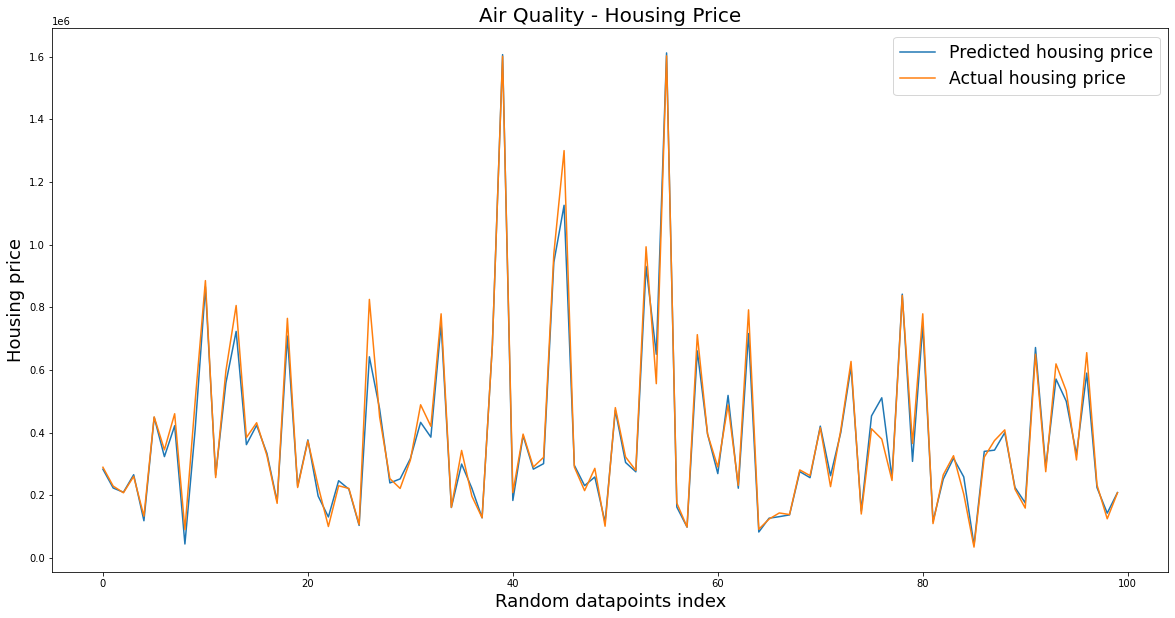

In [ ]:
compare(tf_nn_air, X_test_air, list(y_test_air), 100, 'Air Quality - Housing Price')

In [ ]:
tf_nn_air.save('/content/drive/MyDrive/560 -Team Random/colab/DNN_air.h5')

In [ ]:
DNN_from_saved = tf.keras.models.load_model('DNN_air.h5', custom_objects={"rmse": rmse})
#DNN_from_saved = tf.keras.models.load_model('DNN_air.h5')

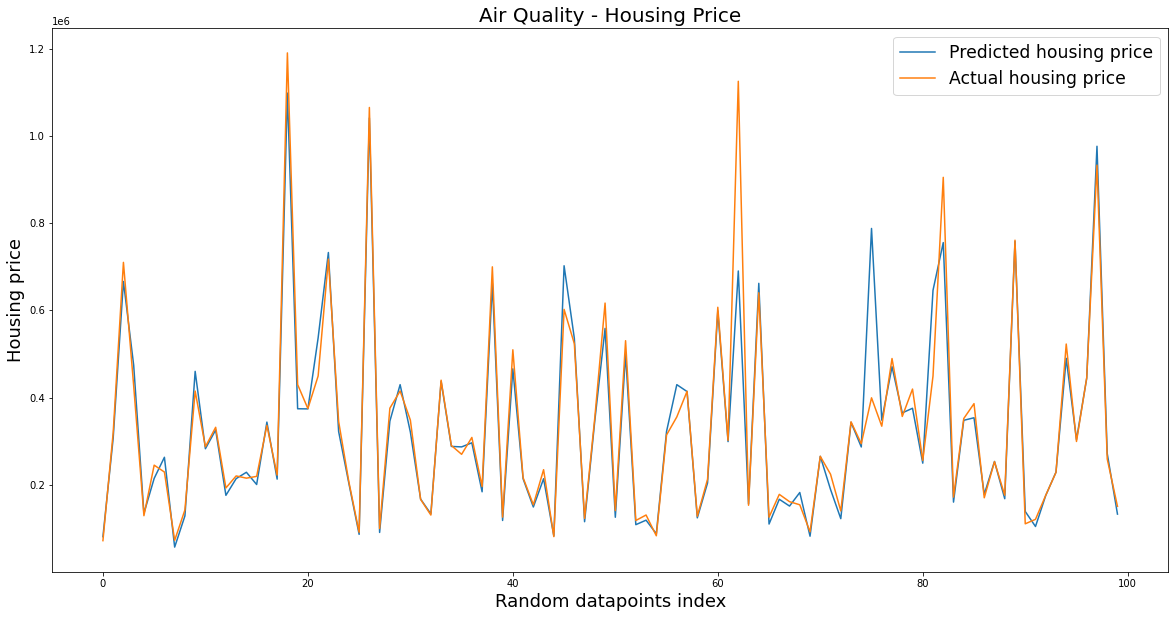

In [ ]:
compare(DNN_from_saved, X_test_air, list(y_test_air), 100, 'Air Quality - Housing Price')

In [ ]:
# Oil quality - housing price Tensorflow DNN model

In [ ]:
oil.head()

,price,SpudAge,ActiveWellRatio,house_price_age,Alameda,Amador,Butte,Del Norte,Fresno,Glenn,...,Siskiyou,Solano,Sonoma,Stanislaus,Sutter,Tehama,Tulare,Ventura,Yolo,Yuba
0,226149.0,60.547368,0.063158,32,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,219306.0,60.547368,0.063158,32,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,225162.0,60.547368,0.063158,32,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,229333.0,60.547368,0.063158,32,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,232291.0,60.547368,0.063158,32,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
len(oil.columns)

47

In [ ]:
oil['ActiveWellRatio'].min()

0.0

In [ ]:
spudage = 50 # 29 to 102
well_ratio = 0.1 # 0 to 0.3

oil_pollution = {
    'SpudAge': spudage,
    'ActiveWellRatio': well_ratio,
    'house_price_age': price_age
}

oil_county = ['Alameda','Amador', 'Butte', 'Del Norte', 'Fresno', 'Glenn', 'Humboldt', 'Kern',
              'Kings', 'Lake', 'Lassen', 'Los Angeles', 'Madera', 'Marin',
              'Mendocino', 'Merced', 'Mono', 'Monterey', 'Napa', 'Orange', 'Placer',
              'Riverside', 'Sacramento', 'San Benito', 'San Bernardino', 'San Diego',
              'San Joaquin', 'San Luis Obispo', 'San Mateo', 'Santa Barbara',
              'Santa Clara', 'Santa Cruz', 'Shasta', 'Siskiyou', 'Solano', 'Sonoma',
              'Stanislaus', 'Sutter', 'Tehama', 'Tulare', 'Ventura', 'Yolo', 'Yuba']

In [ ]:
X_train_oil, X_test_oil, y_train_oil, y_test_oil = train_test_split(oil.iloc[:, 1:], oil['price'], test_size=0.33, random_state=42)
X_train_oil, X_test_oil = prepareTrainingData(X_train_oil, X_test_oil, 3)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
X_test_oil.shape

(4546, 46)

In [ ]:
tf_nn_oil = keras.models.Sequential([
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1)
])

tf_nn_oil.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),
                  loss=rmse,
                  metrics=[rmse])

tf_nn_oil.build(X_train_oil.shape)
tf_nn_oil.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (9228, 128)               6016      
                                                                 
 dense_9 (Dense)             (9228, 256)               33024     
                                                                 
 dense_10 (Dense)            (9228, 256)               65792     
                                                                 
 dense_11 (Dense)            (9228, 128)               32896     
                                                                 
 dense_12 (Dense)            (9228, 1)                 129       
                                                                 
Total params: 137,857
Trainable params: 137,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tf_nn_oil.fit(X_train_oil, y_train_oil, epochs=100)

Epoch 1/100
289/289 [==============================] - 2s 4ms/step - loss: 135821.5469 - rmse: 135757.7500
Epoch 2/100
289/289 [==============================] - 1s 4ms/step - loss: 90698.0703 - rmse: 90597.9531
Epoch 3/100
289/289 [==============================] - 1s 4ms/step - loss: 70365.5938 - rmse: 70306.5000
Epoch 4/100
289/289 [==============================] - 1s 4ms/step - loss: 66912.6328 - rmse: 66850.3125
Epoch 5/100
289/289 [==============================] - 1s 4ms/step - loss: 64426.4023 - rmse: 64451.2578
Epoch 6/100
289/289 [==============================] - 1s 4ms/step - loss: 57705.8281 - rmse: 57625.5039
Epoch 7/100
289/289 [==============================] - 1s 4ms/step - loss: 55650.5820 - rmse: 55630.1367
Epoch 8/100
289/289 [==============================] - 1s 4ms/step - loss: 51159.1719 - rmse: 51110.7031
Epoch 9/100
289/289 [==============================] - 1s 4ms/step - loss: 52950.3047 - rmse: 52910.2422
Epoch 10/100
289/289 [==============================]

In [ ]:
printPerformance(tf_nn_oil, X_test_oil, y_test_oil, 'Oil quality')

rmse for Oil quality - housing price Tensorflow DNN model is 43840.376969797326
r-squared for the Oil quality - housing price Tensorflow DNN model is 0.9709090005020353


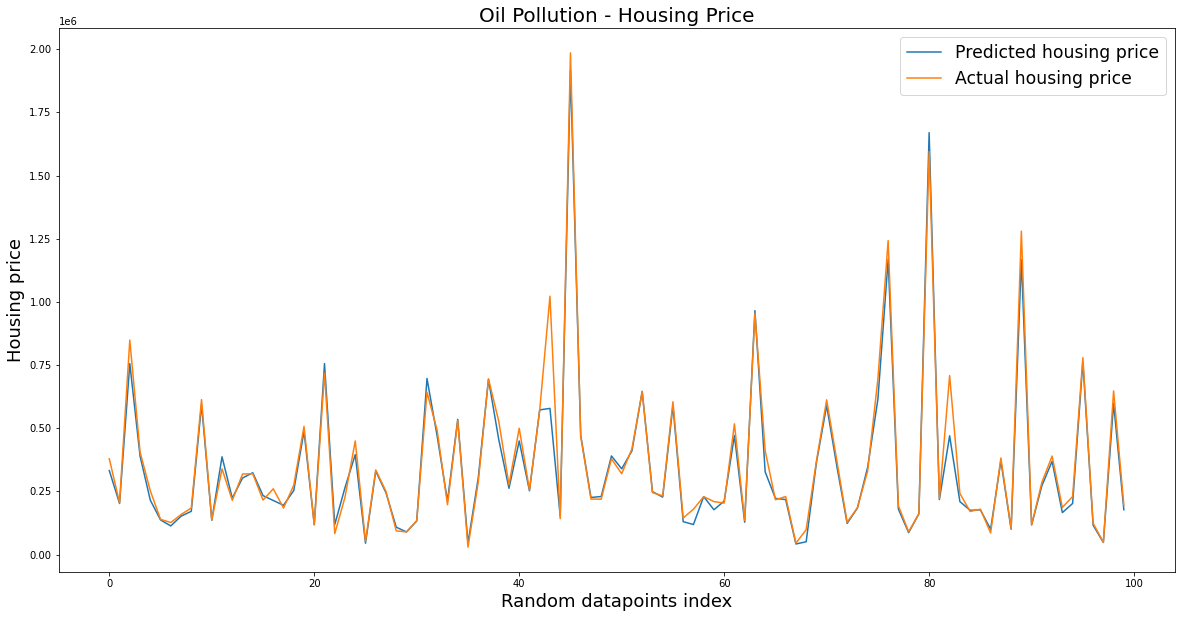

In [ ]:
compare(tf_nn_oil, X_test_oil, list(y_test_oil), 100, 'Oil Pollution - Housing Price')

In [ ]:
tf_nn_oil.save('/content/drive/MyDrive/560 -Team Random/colab/DNN_oil.h5')

In [ ]:
DNN_from_saved = tf.keras.models.load_model('/content/drive/MyDrive/560 -Team Random/colab/DNN_oil.h5', custom_objects={"rmse": rmse})
#DNN_from_saved = tf.keras.models.load_model('DNN_air.h5')

ValueError: ignored

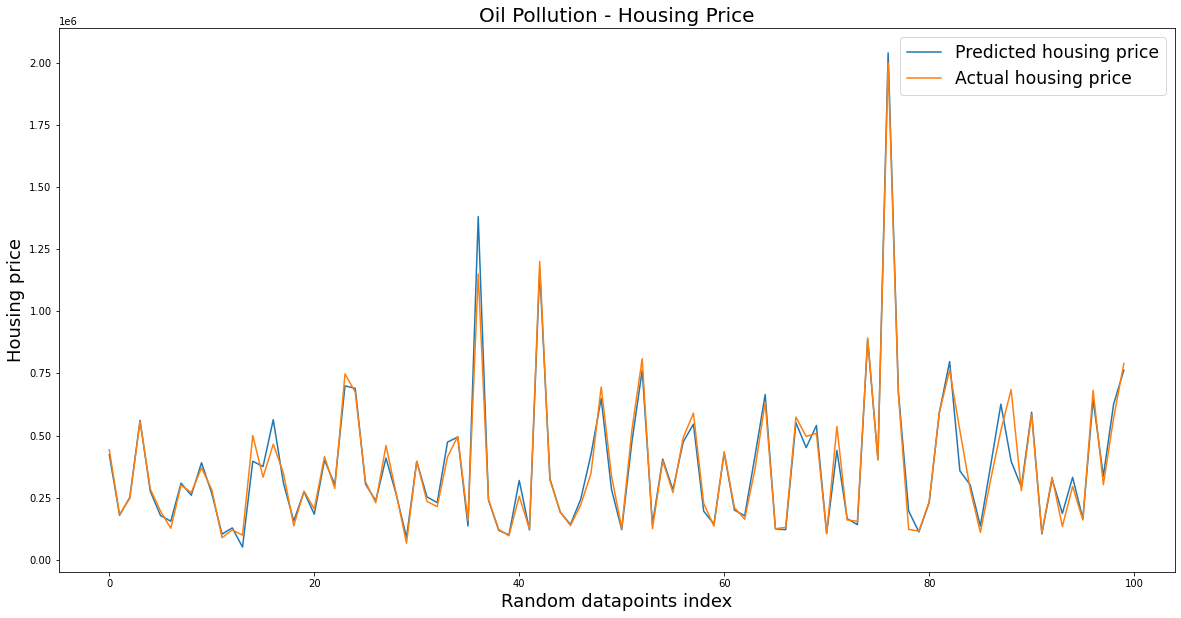

In [ ]:
compare(DNN_from_saved, X_test_oil, list(y_test_oil), 100, 'Oil Pollution - Housing Price')

In [ ]:
# Water quality - housing price Tensorflow DNN model

In [ ]:
water.head()

,price,Result,Polluted,Ratio,house_price_age,Alameda,Amador,Butte,Calaveras,Del Norte,...,"p,p'-DDD","p,p'-DDE","p,p'-DDT",p-Xylene,pH,"s,s,s-Tributyl Phosphorotrithioate (DEF)",sec-Butylbenzene,tert-Butylbenzene,"trans-1,2-Dichloroethene","trans-1,3-Dichloropropene"
0,226149.0,120.0,True,12.0,32,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,226149.0,0.0,False,0.0,32,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,226149.0,360.0,True,36.0,32,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,226149.0,25.0,True,5.0,32,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,226149.0,849.0,True,849.0,32,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
water.drop(['Ratio'], axis=1, inplace=True) # drop ratio because it contains inf
water['Polluted'] = water['Polluted'].apply(lambda x: int(x)) # convert boolean to binary

In [ ]:
water['Result'].max()

5000000.0

In [ ]:
result = 300 # -1 to 5000000.0
polluted = 1 # 0 or 1

water_pollution = {
    'Result': result,
    'Polluted': polluted,
    'house_price_age': price_age
}

In [ ]:
water['Dissolved Carbonate (CO3--)'].value_counts()

0.0    657615
1.0       270
Name: Dissolved Carbonate (CO3--), dtype: int64

In [ ]:
water_pollution_list = list(water.iloc[:,49:].columns)
water_pollution_index = dict()
for idx, name in enumerate(water_pollution_list):
  water_pollution_index[name] = idx

water_pollution_type = [0] * len(water_pollution_list)
selected_pollution = ['Bromacil', 'Carbofuran', 'Diuron']
for pollution in selected_pollution:
  water_pollution_type[water_pollution_index[pollution]] = 1

water_pollution_type

In [ ]:
list(water.iloc[:,49:].mean())

In [ ]:
+ 

NameError: ignored

In [ ]:
water.head()

,price,Result,Polluted,house_price_age,Alameda,Amador,Butte,Calaveras,Del Norte,El Dorado,...,"p,p'-DDD","p,p'-DDE","p,p'-DDT",p-Xylene,pH,"s,s,s-Tributyl Phosphorotrithioate (DEF)",sec-Butylbenzene,tert-Butylbenzene,"trans-1,2-Dichloroethene","trans-1,3-Dichloropropene"
0,226149.0,120.0,1,32,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,226149.0,0.0,0,32,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,226149.0,360.0,1,32,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,226149.0,25.0,1,32,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,226149.0,849.0,1,32,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_train_water, X_test_water, y_train_water, y_test_water = train_test_split(water.iloc[:, 1:], water['price'], test_size=0.33, random_state=42)

In [ ]:
X_train_water, X_test_water = prepareTrainingData(X_train_water, X_test_water, 3)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
X_test_water.shape

(217103, 418)

In [ ]:
water_county = ['Alameda', 'Amador', 'Butte', 'Calaveras','Del Norte',
                'El Dorado','Fresno','Glenn','Humboldt','Kern','Kings',
                'Lake','Lassen','Los Angeles','Marin','Mendocino','Merced',
                'Mono','Monterey','Napa','Nevada','Placer','Plumas',
                'Riverside','Sacramento','San Benito','San Bernardino',
                'San Diego','San Joaquin','San Luis Obispo','Santa Barbara',
                'Santa Clara','Santa Cruz','Shasta','Siskiyou','Solano','Sonoma',
                'Stanislaus','Sutter','Tehama','Tulare','Tuolumne','Ventura',
                'Yolo','Yuba']

In [ ]:
tf_nn_water = keras.models.Sequential([
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dense(1)
])

tf_nn_water.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),
                  loss=rmse,
                  metrics=[rmse])

tf_nn_water.build(X_train_water.shape)
tf_nn_water.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (440782, 128)             53632     
                                                                 
 dense_1 (Dense)             (440782, 64)              8256      
                                                                 
 dense_2 (Dense)             (440782, 1)               65        
                                                                 
Total params: 61,953
Trainable params: 61,953
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tf_nn_water.fit(X_train_water, y_train_water, epochs=30)

Epoch 1/30
13775/13775 [==============================] - 77s 5ms/step - loss: 40000.5508 - rmse: 40000.1523
Epoch 2/30
13775/13775 [==============================] - 75s 5ms/step - loss: 24762.3555 - rmse: 24762.3691
Epoch 3/30
13775/13775 [==============================] - 53s 4ms/step - loss: 22792.7285 - rmse: 22792.5781
Epoch 4/30
13775/13775 [==============================] - 52s 4ms/step - loss: 21845.8516 - rmse: 21845.5391
Epoch 5/30
13775/13775 [==============================] - 53s 4ms/step - loss: 21870.3242 - rmse: 21870.0469
Epoch 6/30
13775/13775 [==============================] - 52s 4ms/step - loss: 21073.3828 - rmse: 21072.9531
Epoch 7/30
13775/13775 [==============================] - 53s 4ms/step - loss: 20758.5195 - rmse: 20758.4199
Epoch 8/30
13775/13775 [==============================] - 54s 4ms/step - loss: 20483.5293 - rmse: 20483.4824
Epoch 9/30
13775/13775 [==============================] - 54s 4ms/step - loss: 20349.4883 - rmse: 20349.4590
Epoch 10/30
13775/1

In [ ]:
printPerformance(tf_nn_water, X_test_water, y_test_water, 'water quality')

rmse for water quality - housing price Tensorflow DNN model is 20086.39302367701
r-squared for the water quality - housing price Tensorflow DNN model is 0.9836373227572504


In [ ]:
tf_nn_water.save('/content/drive/MyDrive/560 -Team Random/colab/DNN_water.h5')

In [ ]:
DNN_from_saved = tf.keras.models.load_model('/content/drive/MyDrive/560 -Team Random/colab/DNN_water.h5', custom_objects={"rmse": rmse})
#DNN_from_saved = tf.keras.models.load_model('DNN_air.h5')

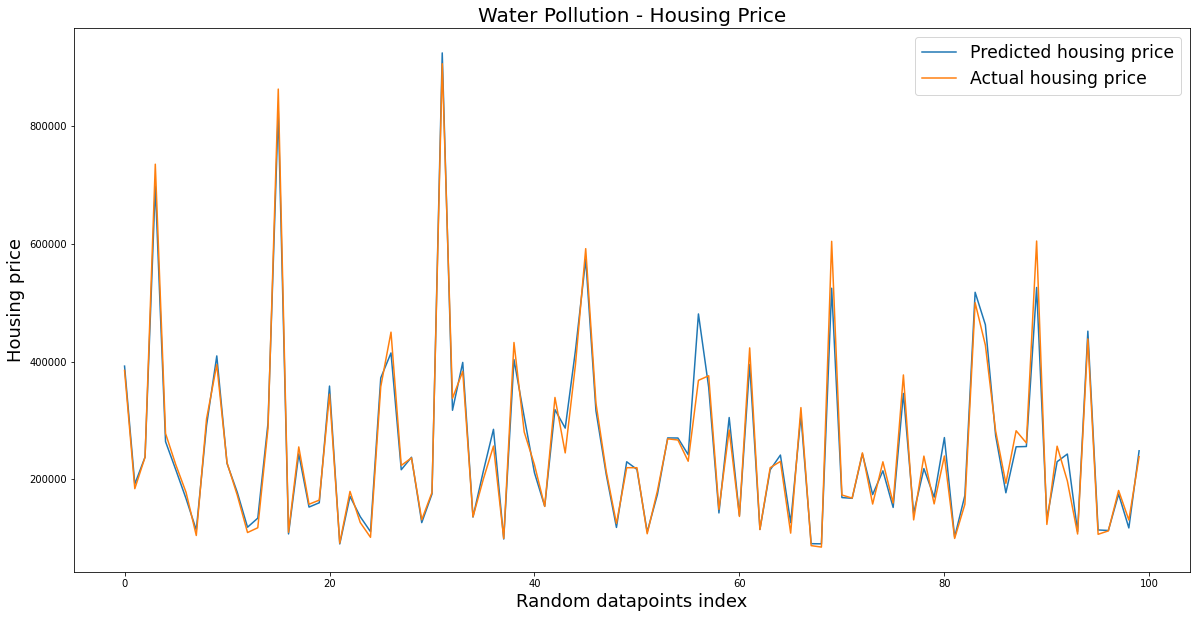

In [ ]:
compare(DNN_from_saved, X_test_water, list(y_test_water), 100, 'Water Pollution - Housing Price')

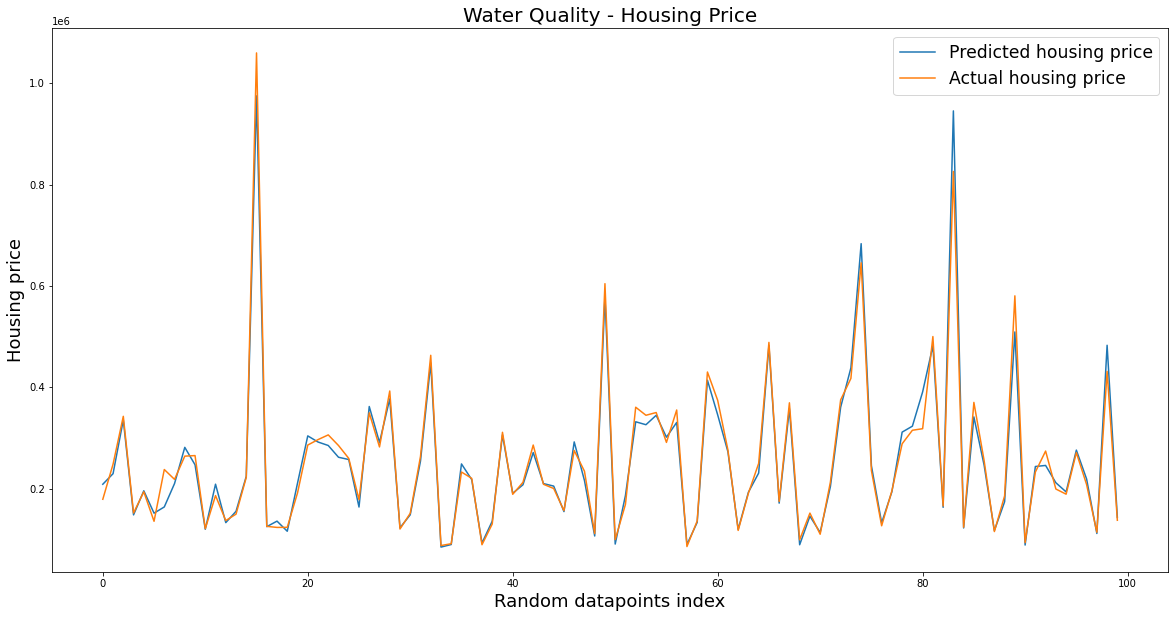

In [ ]:
compare(tf_nn_water, X_test_water, list(y_test_water), 100, 'Water Quality - Housing Price')